In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm

# module containing the main functions
import utils as ut

In [2]:
def stop_cond(_vars, pars):
    """
    Stop condition of having the positive growth rate theta times smaller 
    than gamma
    """
    Ts, P, Ss = _vars
    growth_rates = pars.betas * P * (1 - Ss)
    gr_small_than_th = np.sum(growth_rates / pars.gamma < theta)
    return gr_small_than_th >= pars.n

def generate_ensamble(R, tau_sampler, **params):
    # Initializing parameters with default values or corrected through **params
    pars = ut.TT_params([1], **params)

    progress = tqdm(total=R)
    taus_mat, Tfreqs_mat = [], []
    for _ in range(R):
        tau_sampler.sample()
        taus_mat.append(tau_sampler.taus)
        pars.set_taus(tau_sampler.taus)
        times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, tau_sampler, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)
        Tfreqs_mat.append(T_trajs[-1] / T_trajs[-1].sum())
        progress.update(1)
        
    return taus_mat, Tfreqs_mat
    
def sq_func(x, a, b, c):
    return a*x**2 + b*x + c

# Phase diagram varying $\tau_{crit}$ and $\alpha_0$ 
### Explaining the procedure step by step

In [3]:
# Parameters kept fix 

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 500, 'adapt', 30

# Stopping condition parameter (discussed below)
theta = 0.2  

# Fraction of trajectories with maximum to determine the non-monotoncity (discussed below)
no_max_perc = 0.9

# Minimal frequency at maximum
min_freq_max = 2 / tau_samp.n_samples

## Which time to use for computing the diagram observables?

Condition: all the $T_i$ trajectories have a positive growth rate smaller than the constant death rate (memory phase when the expansion due to antigens is small):
$$
\beta_i P(t) (1 - S_i(t)) / \gamma < \theta 
$$
where $\theta$ is a threshold to be chosen.

In [4]:
pars = ut.TT_params(tau_samp.taus)

%time times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, tau_samp, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)

CPU times: user 239 ms, sys: 2.97 ms, total: 242 ms
Wall time: 240 ms


In [5]:
theta = 0.2
growth_rates = pars.betas[np.newaxis,:] * P_trajs[:,np.newaxis] * (1 - S_trajs)
gr_small_than_th = np.sum(growth_rates / pars.gamma < theta, axis=1)

time_memory_i = len(times) - np.sum(gr_small_than_th == pars.n)
if time_memory_i == len(times):
    print('memory time not reached')
else:
    time_memory = times[time_memory_i]
    print('Time at which the positive growth rate is "much" smaller than the death rate:', time_memory)

Time at which the positive growth rate is "much" smaller than the death rate: 42.75


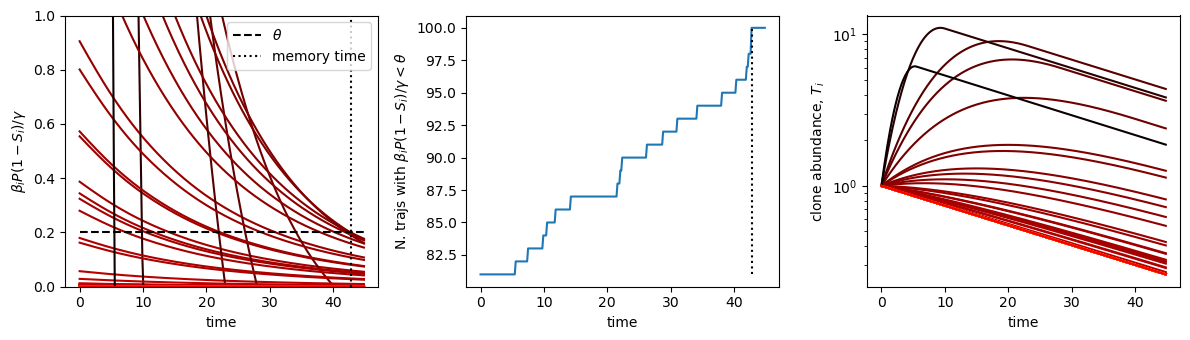

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 3.5))

cmap = colormaps.get_cmap('hot_r')
cmap_norm = plt.Normalize(vmin=min(np.log10(tau_samp.taus)), vmax=max(np.log10(tau_samp.taus)))

ax1.set_ylim(0,1)
ax1.set_ylabel(r'$\beta_i P (1 - S_i) / \gamma$')
ax1.set_xlabel('time')
for i, gr in enumerate(growth_rates.T):
    color = cmap(cmap_norm(np.log10(tau_samp.taus[i])))
    ax1.plot(times, gr/pars.gamma, c=color)
ax1.plot(times, theta * np.ones(len(times)), ls='--', c='k', label=r'$\theta$')
ax1.plot([time_memory, time_memory], [0, 1], ls=':', c='k', label='memory time')
ax1.legend()

ax2.set_ylabel(r'N. trajs with $\beta_i P (1 - S_i) / \gamma < \theta$')
ax2.set_xlabel('time')
ax2.plot(times, gr_small_than_th)
ax2.plot([time_memory, time_memory], [min(gr_small_than_th), pars.n], ls=':', c='k')

ax3.set_yscale('log')
ax3.set_xlabel('time')
ax3.set_ylabel(r'clone abundance, $T_i$')
for i, Ts in enumerate(T_trajs.T):
    color = cmap(cmap_norm(np.log10(tau_samp.taus[i])))
    ax3.plot(times, Ts, c=color)
    
plt.tight_layout()

## Detecting the maximum of abundance-affinity plot in an ensemble

The most consistent way of doing it seems to use the ensamble of trajectories of the derivative and check when it crosses the zero.

I tried also by using the scatter plot of all the points tau-T generated in the ensamble, but this cloud seems to bias the position of the maximum and I can find fake maximums also in case of alpha0 = 0.

Procedure to compute maximum which returns $x_{max}$, $y_{max}$ and $n{max}$ (how many trajectories show a max):
- Generate $R$ systems with given parameters and obtain the $\tau_i$-$f_i$ scatter ($f_i$ is the fraction of cells in clone $i$).
- Log transform the two variables: $x_i = \log_{10} \tau_i$,  $y_i = \log_{10} f_i$.
- Compute the curve of the slopes between consecutive points: $d_i = \Delta y_i / \Delta x_i$.
- Compute the average of this ensemble of trajectories $d_i$-$x_i$ and find the point where it crosses 0, this gives $x_{max}$.
- Count how many maxima have been found $n_{max}$ by looking if the single trajectory contains the position $x_{max}$ and if it ends as a decreasing function.
- For the trajectories that have a max (condition above) compute the intersection at $x_{max}$ to get $y_{max,i}$ and the average to get $y_{max}$.
- 
Condition to exclude an ensemble maximum:
- If the fraction of trajectories not having a max is larger than `no_max_perc` then the ensamble is considered monotonous increasing.
- If the frequencies at which we find the maximum is smaller than $2/N$ we consider this maximum not observable.

In [13]:
def find_first_zero(xs, ys):
    for i in range(1, len(xs)):
        x0, y0, x1, y1 = xs[i-1], ys[i-1], xs[i], ys[i]
        if y0*y1 < 0:
            # Linear interpolation to get the zero
            x_max = x1 + y1*(x0-x1)/(y1-y0)
            return x_max

def find_max(taus_mat, Tfreqs_mat, smooth_bins=100):
    """
    Method for detecting an average maximum in an ensemble of tau-freq curves
    """
    # Moving to the log transformed variables, sorting them and taking the derivative
    logtaus, logTfreq = np.log10(taus_mat), np.log10(Tfreqs_mat)
    tau_sort_i = np.argsort(logtaus, axis=1)
    logtaus = np.take_along_axis(logtaus, tau_sort_i, axis=1)
    logTfreq = np.take_along_axis(logTfreq, tau_sort_i, axis=1)
    ders = (logTfreq[:,1:] - logTfreq[:,:-1]) / (logtaus[:,1:] - logtaus[:,:-1])
    mid_logtaus = (logtaus[:,1:] + logtaus[:,:-1]) / 2.0

    # Computing the average trajectory
    bins = np.linspace(np.min(mid_logtaus), np.max(mid_logtaus), smooth_bins)
    smooth_x, smooth_y, _, _ = ut.binning_x(mid_logtaus.flatten(), ders.flatten(), bins)
    
    # Finding the zero of the smoothed trajectory
    x_max = find_first_zero(smooth_x, smooth_y)

    # Counting how many trajectories cross the average maximum and are decreasing at the end
    max_mask = np.logical_and(logtaus[:,-1] > x_max, ders[:,-1] < 0)
    n_x_max = np.sum(max_mask)
    
    # Estimating the average y at max
    y_maxs = []
    for r in range(len(taus_mat)):
        if max_mask[r]:
            y_maxs.append(np.interp(x_max, logtaus[r], logTfreq[r]))
    y_max = np.mean(y_maxs)
    
    return x_max, y_max, n_x_max


def evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, min_freq_max=min_freq_max, verbose=False):
    if y_max < np.log10(min_freq_max):
        if verbose: print('Maximum at almost minimal frequecy')
        y_max = float('nan')
    if ((R - n_x_max) / R > no_max_perc):
        print('Not enough trajectories have a max')
        x_max = float('nan')
    return x_max, y_max
    

def plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, smooth_bins=100, xlim=(-2,2)):
    """
    Plotting derivatives and logT vs. logtau trajectories with the identified maximum
    """
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))
    
    ax1.set_ylabel(r'$\Delta \log_{10} T / \Delta \log_{10} \tau$')
    ax1.set_xlabel(r'affinity, $\log_{10}\tau_i$')
    ax1.set_xlim(xlim)
    
    logtaus, logTfreq = np.log10(taus_mat), np.log10(Tfreqs_mat)
    tau_sort_i = np.argsort(logtaus, axis=1)
    logtaus = np.take_along_axis(logtaus, tau_sort_i, axis=1)
    logTfreq = np.take_along_axis(logTfreq, tau_sort_i, axis=1)
    ders = (logTfreq[:,1:] - logTfreq[:,:-1]) / (logtaus[:,1:] - logtaus[:,:-1])
    mid_logtaus = (logtaus[:,1:] + logtaus[:,:-1]) / 2.0
    bins = np.linspace(np.min(mid_logtaus), np.max(mid_logtaus), smooth_bins)
    smooth_x, smooth_y, _, _ = ut.binning_x(mid_logtaus.flatten(), ders.flatten(), bins)
    
    for r in range(R):
        ax1.plot(mid_logtaus[r], ders[r], c='b', alpha=0.2)
    ax1.plot(smooth_x, smooth_y, c='r', label='average')
    xs = np.linspace(np.min(mid_logtaus), np.max(mid_logtaus), 2)
    ax1.plot(xs, np.zeros(len(xs)), c='k', ls=':')
    ys = np.linspace(np.min(ders), np.max(ders), 2)
    ax1.plot([x_max, x_max], ys, c='k', label='maximum x')
    ax1.legend()
    
    ax2.set_ylabel(r'clone log frequency $\log_{10} T_i$')
    ax2.set_xlabel(r'affinity, $\log_{10}\tau_i$')
    ax2.set_xlim(xlim)
    for r in range(R):
        ax2.plot(logtaus[r], logTfreq[r], c='b', alpha=0.2)
    ys = np.linspace(np.min(logTfreq), np.max(logTfreq), 2)
    ax2.plot([x_max, x_max], ys, c='k')
    ax2.plot(xs, np.ones(len(xs))*y_max, c='k', ls='--')
    
    return ax1, ax2

#### Case with a clear maximum

In [14]:
R = 200
taus_mat, Tfreqs_mat = generate_ensamble(R, tau_samp, alpha0=1e-4)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max, y_max = evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, verbose=True)
#print(x_max, y_max)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.25it/s]


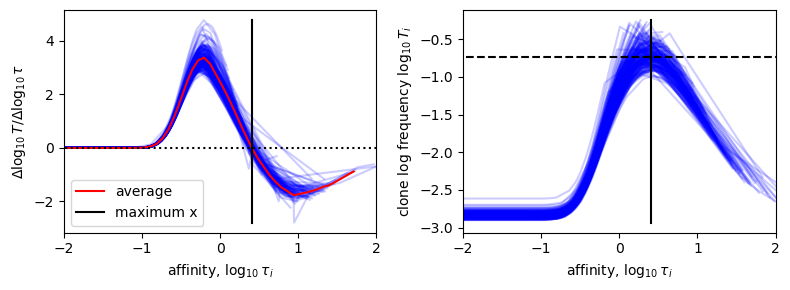

In [15]:
ax1, ax2 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max)
plt.tight_layout()

#### Case with many trajectories not having a maximum 
Some trajectories show a maximum, some others do not. I trust the maximum only if the number not showing a max is smaller than `no_max_perc`

In [17]:
R = 200
taus_mat, Tfreqs_mat = generate_ensamble(R, tau_samp, alpha0=1e-5)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max, y_max = evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max, n_x_max/R)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.36it/s]

0.9839947431619058 -0.5953854574406174 0.265


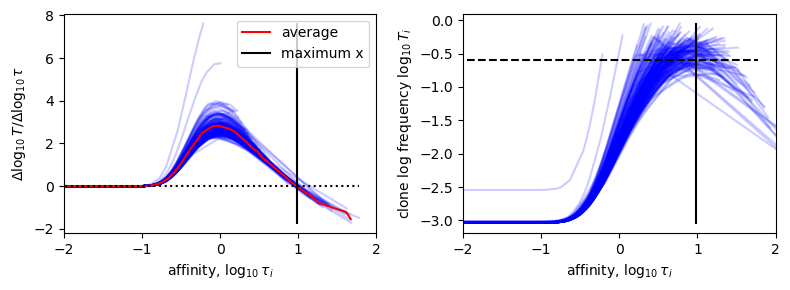

In [18]:
ax1, ax2 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max)
plt.tight_layout()

#### Always increasing case for small inhibition
Mote that some trajectories can still have a very large max affinity that show a maximum, but their fraction should be smaller that the threshold `no_max_perc`

In [19]:
R = 200
taus_mat, Tfreqs_mat = generate_ensamble(R, tau_samp, alpha0=1e-6)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max, y_max = evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.86it/s]

Not enough trajectories have a max
nan -0.5383977051743385


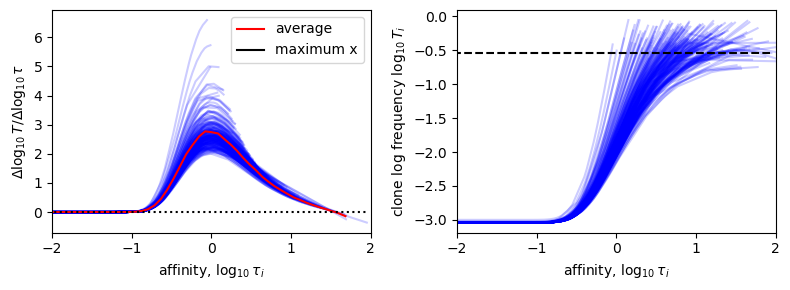

In [20]:
ax1, ax2 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max)
plt.tight_layout()

#### Strong inhibition

With too much inhibition the procedure still finds a maximum due to the noisy behavior of the trajectories even if it does not look like a max anymore.
However we can use $y_{max}$ to say that this is not really a max, because $y_{max} \approx 1/N$, and therefore those are almost extinct clones.

In [23]:
R = 200
taus_mat, Tfreqs_mat = generate_ensamble(R, tau_samp, alpha0=1e-1)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max, y_max = evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.61it/s]

Maximum at almost minimal frequecy
-0.13661779119710382 nan


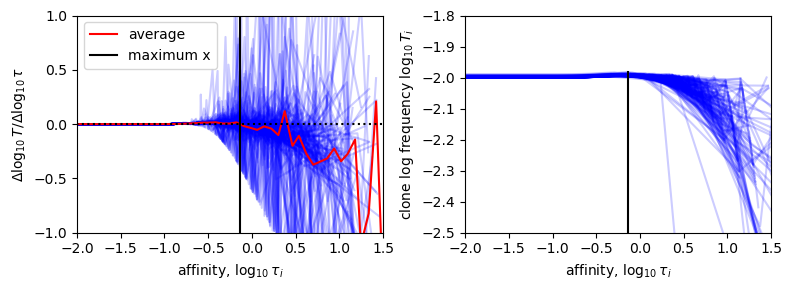

In [24]:
ax1, ax2 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, xlim=(-2.0, 1.5))
ax1.set_ylim(-1,1)
ax2.set_ylim(-2.5,-1.8)
plt.tight_layout()